# 2. Normalization

**Best practice 1.0**

* We recommend scran for normalization of non-full-length datasets. An alternative is to evaluate normalization approaches via scone especially for plate-based datasets. Full-length scRNA-seq protocols can be corrected for gene length using bulk methods.
* There is no consensus on scaling genes to 0 mean and unit variance. We prefer not to scale gene expression.
* Normalized data should be log(x+1)-transformed for use with downstream analysis methods that assume data are normally distributed.

**New benchmark:** Germain, PL., Sonrel, A. & Robinson, M.D. pipeComp, a general framework for the evaluation of computational pipelines, reveals performant single cell RNA-seq preprocessing tools. Genome Biol 21, 227 (2020). https://doi.org/10.1186/s13059-020-02136-7

**Conclusion:**
* Most normalization methods tested yielded a fair performance, especially when combined with scaling, which tended to have a positive impact on clustering.

* `sctransform` offered the best overall performance in terms of the separability of the subpopulations, as well as removing the effect of library size and detection rate.

* The common practice of regressing out cell covariates, such as the detection rate or proportion of mitochondrial reads nearly always had a negative impact, leading to increased correlation with covariates and decreased clustering accuracy. We therefore advise against this practice.


## Loading the libraries

In [1]:
import scanpy as sc
import numpy as np
import seaborn as sns
from scipy.sparse import issparse

import matplotlib.pyplot as plt
from matplotlib import colors

import rpy2.robjects as ro

import rpy2.rinterface_lib.callbacks
import logging

import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
ro.pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

sc.settings.verbosity = 3
sc.set_figure_params(dpi=200, dpi_save=300)
plt.rcParams['figure.figsize']=(4,4) #rescale figures
#sc.logging.print_versions()

In [3]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(Seurat)
library(scater)
library(scran)

## Reading in the data
* read the data and mention introduction on how to get the AnnData object from e.g. a GEO object
* **Note to us:** have a minimal AnnData object here, so the reader is not overwhelmed

In [4]:
adata = sc.read('endocrinogenesis_day15.h5ad')
adata

/Users/anna.schaar/opt/miniconda3/envs/bp2_hackathon/lib/python3.8/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/anna.schaar/opt/miniconda3/envs/bp2_hackathon/lib/python3.8/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

## 2.1 Quality Control 

In [20]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = np.array(adata.X.sum(1))
adata.obs['log_counts'] = np.log(adata.obs['n_counts']).T
adata.obs['n_genes'] = (adata.X.toarray() > 0).sum(1)

#mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]
#adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']


In [6]:
sc.pp.filter_genes(adata, min_cells=5)

filtered out 13083 genes that are detected in less than 5 cells


In [7]:
if issparse(adata.X):
    if not adata.X.has_sorted_indices:
        adata.X.sort_indices()

for key in adata.layers:
    if issparse(adata.layers[key]):
        if not adata.layers[key].has_sorted_indices:
            adata.layers[key].sort_indices()

## 2.2 Normalization

**BP 1.0 intro:**

"Up to this point the data is only available as a count matrix. Counts are representative of molecules that were captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called size factors. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell.

Based on comparisons of normalization methods for differential testing (personal communication from Beathe Vieth), and batch correction [Buettner et al., 2019], the normalization method implemented in the scran package performs best. This method requires a coarse clustering input to improve size factor esimation performance. Thus, we use a simple preprocessing approach and cluster the data at a low resolution to get an input for the size factor estimation. The basic preprocessing includes assuming all size factors are equal (library size normalization to counts per million - CPM) and log-transforming the count data."

### 2.2.1 scran normalization

In [8]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 12 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)


In [9]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T.tocsc()

In [10]:
%%R -i data_mat -i input_groups -o size_factors

#size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)
size_factors = sizeFactors(
    computeSumFactors(SingleCellExperiment(list(counts=data_mat)), clusters = input_groups, min.mean=0.1)
)

In [11]:
#Delete adata_pp
del adata_pp

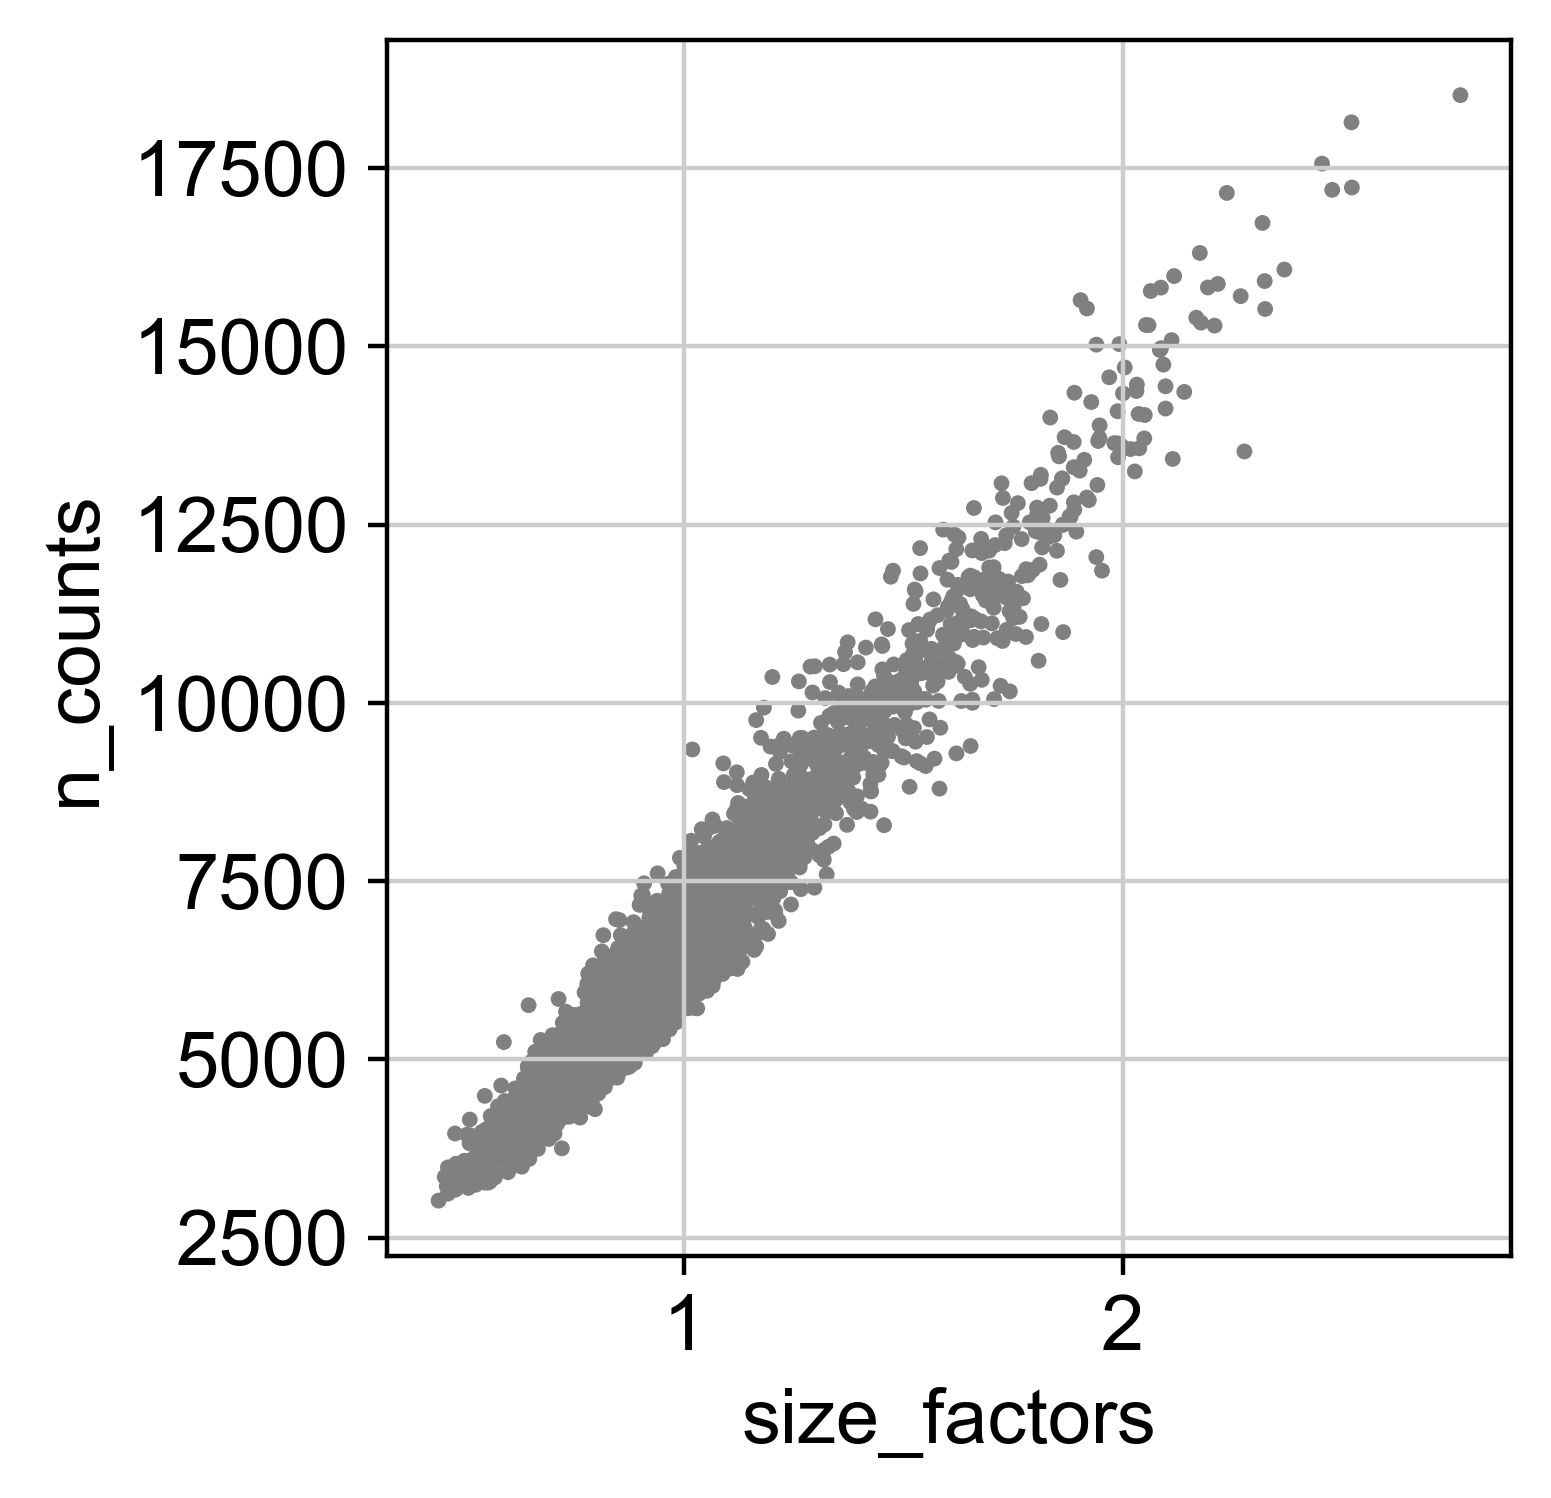

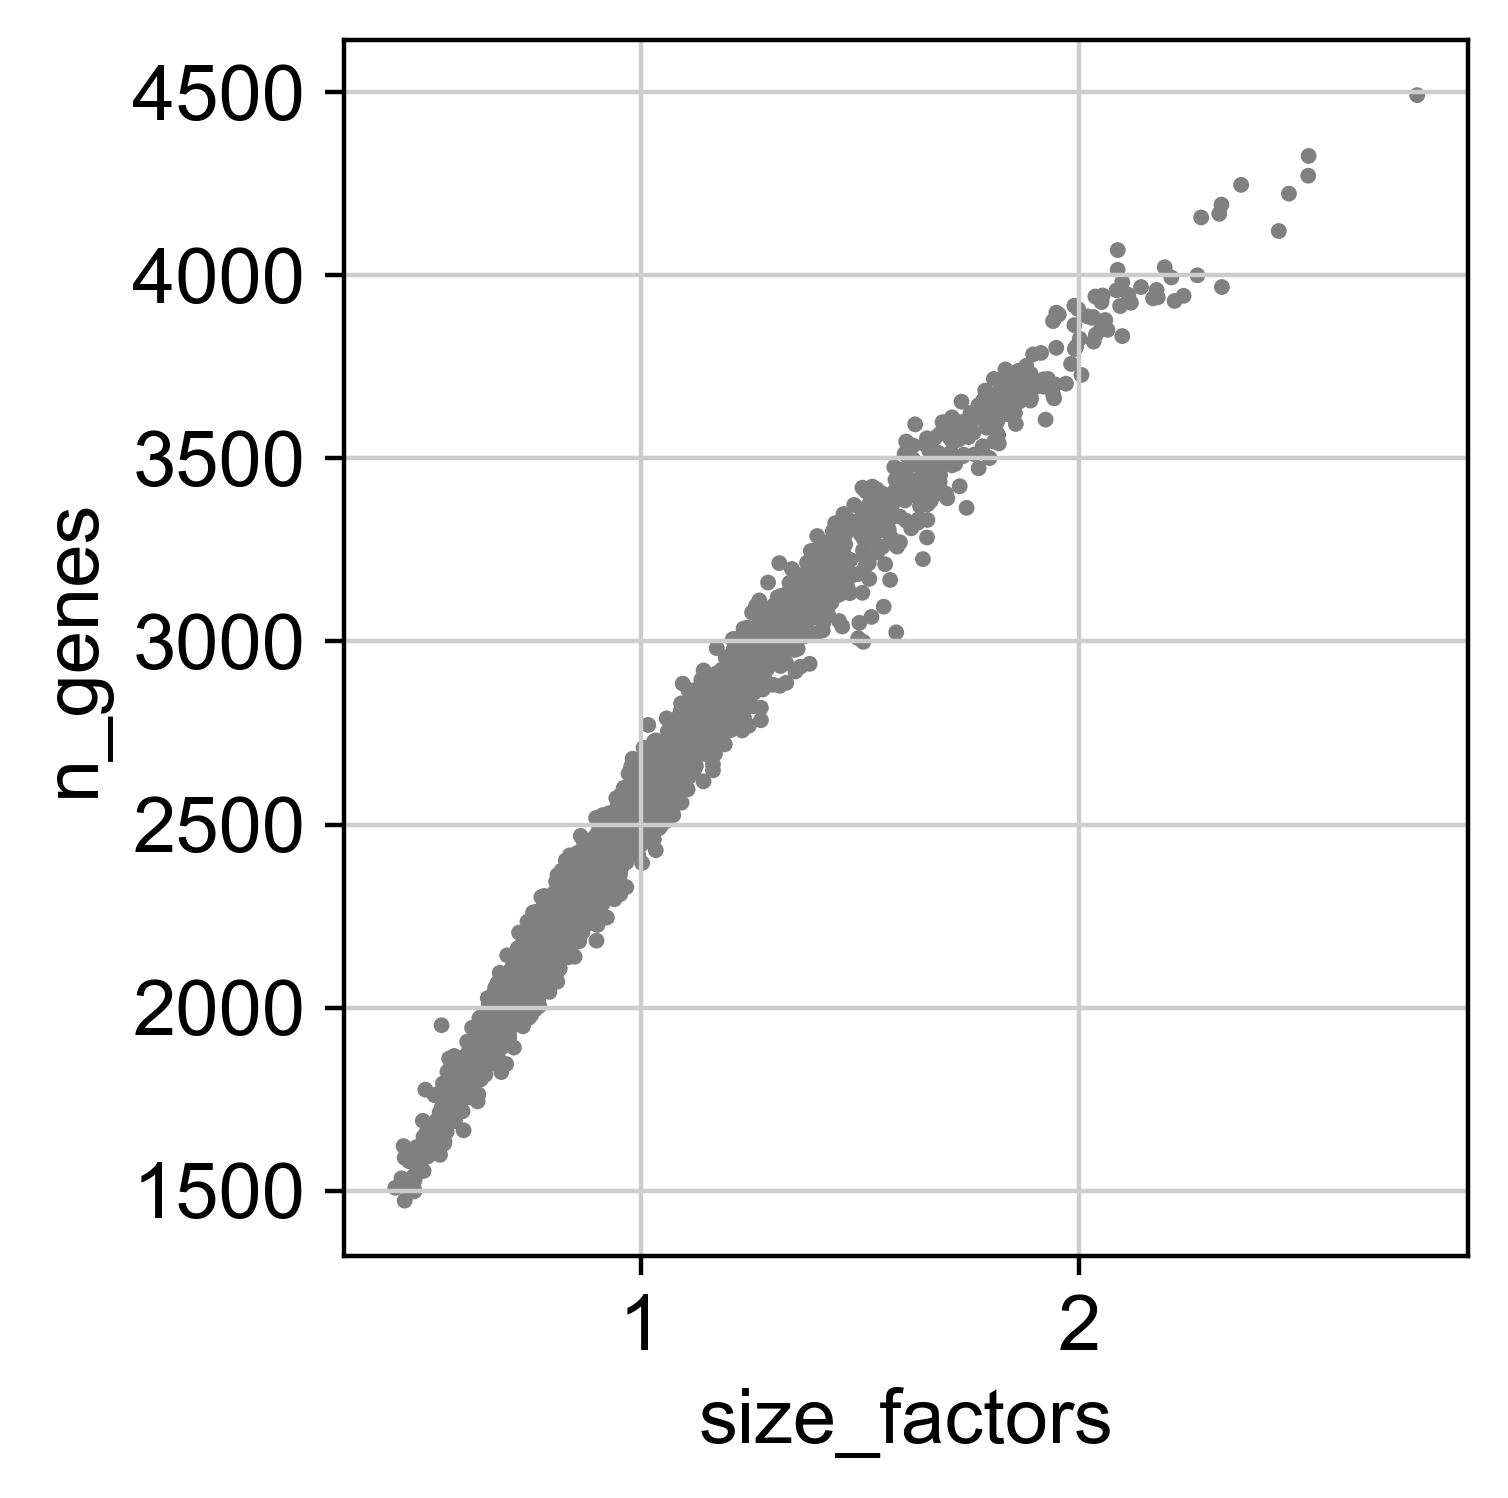

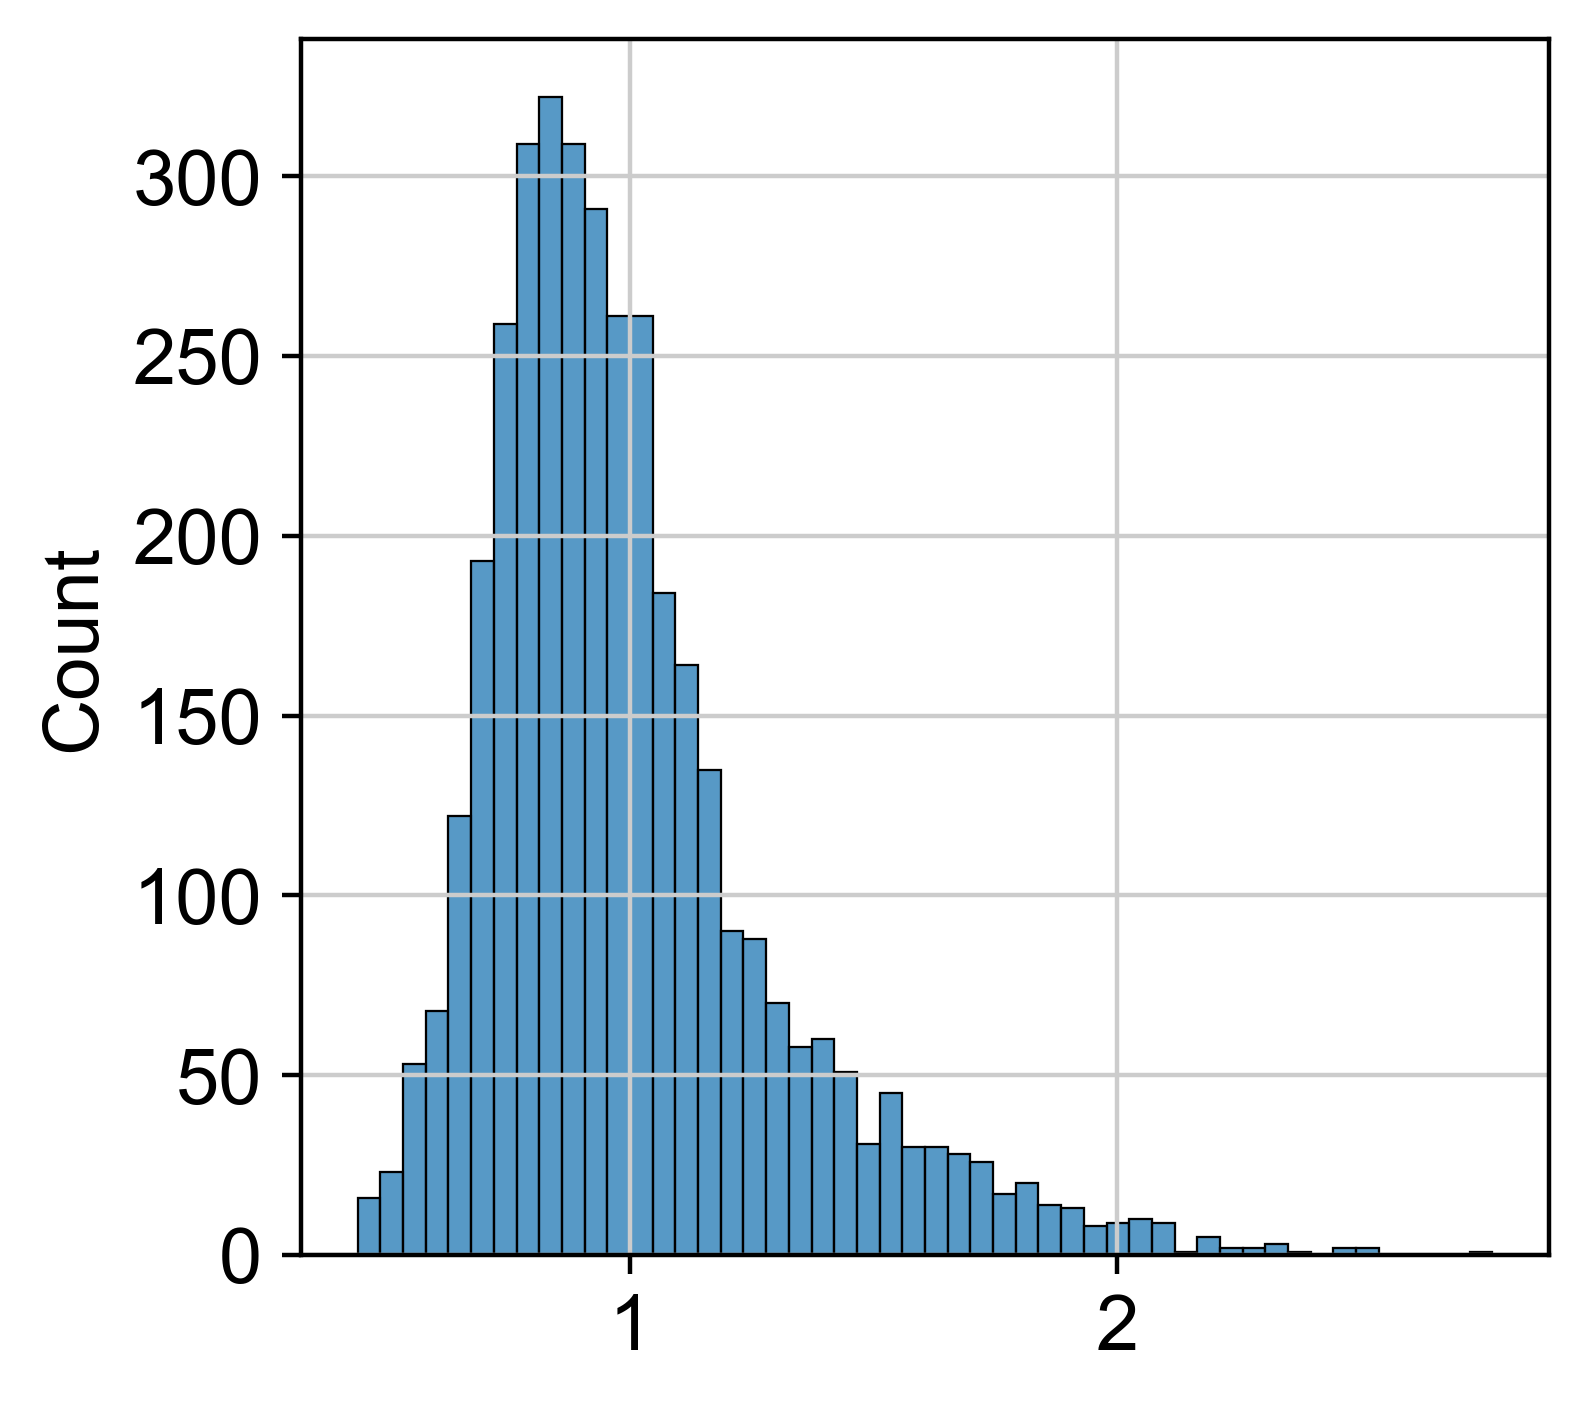

In [12]:
# Visualize the estimated size factors
adata.obs['size_factors'] = np.expand_dims(size_factors, axis=1)

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sns.histplot(size_factors, bins=50, kde=False)
plt.show()

In [13]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [14]:
#Normalize adata 
adata.layers["scran_normalized"] = adata.X / adata.obs['size_factors'].values[:,None]
adata.layers["scran_normalized_log1p"] = sc.pp.log1p(adata.layers["scran_normalized"])

In [15]:
adata

AnnData object with n_obs × n_vars = 3696 × 14915
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'n_counts', 'log_counts', 'n_genes', 'size_factors'
    var: 'highly_variable_genes', 'n_cells'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'counts', 'scran_normalized', 'scran_normalized_log1p'
    obsp: 'distances', 'connectivities'

### 2.2.2 sctransform normalization

In [16]:
%%R -i adata

seurat_obj = as.Seurat(adata, counts="X", data = NULL)
seurat_obj = RenameAssays(seurat_obj, originalexp = "RNA")

In [17]:
%%R

res <- SCTransform(object=seurat_obj, method = "glmGamPoi", return.only.var.genes = FALSE,)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [18]:
norm_x = ro.r('res@assays$SCT@scale.data').T
adata.layers['SCT_normalized_residuals'] = norm_x

In [19]:
adata

AnnData object with n_obs × n_vars = 3696 × 14915
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'n_counts', 'log_counts', 'n_genes', 'size_factors'
    var: 'highly_variable_genes', 'n_cells'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'counts', 'scran_normalized', 'scran_normalized_log1p', 'SCT_normalized_residuals'
    obsp: 'distances', 'connectivities'